In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
DATADIR = "/home/khushi/Testing_testing/Data/Updated_Data"
categories = ["Anaesthesia_machine","baby_incubator","Bone_saws","C_arm","colonoscope","Curved_Mayo_Scissor","difibrillator","Electrocautery_devices","fetal_doppler","forceps","Heart_Lung_Machine","IABP","IMRT","infusion_pump","Laryngoscopes","mayfield_clamp","Needle_Biopsy_Device","phacoemulsification","Radiofrequency_Ablation_Device","Scalpel","Straight_Dissection_Clamp","Straight_Mayo_Scissor","Suction_Machine","ventilator","x_ray"]
input_size = (224, 224)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, categories, input_size, transform=None):
        self.data_dir = data_dir
        self.categories = categories
        self.input_size = input_size
        self.transform = transform
        self.data = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for cat in self.categories:
            path = os.path.join(self.data_dir, cat)
            class_num = self.categories.index(cat)
            for img_name in os.listdir(path):
                try:
                    img_path = os.path.join(path, img_name)
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(self.input_size)
                    if self.transform:
                        img = self.transform(img)
                    self.data.append(img)
                    self.labels.append(class_num)
                except Exception as e:
                    pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        return img, label

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
])

dataset = CustomDataset(DATADIR, categories, input_size, transform=transform)

train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        
        
        super(CustomEfficientNet, self).__init__()
        
        efficientNet = models.efficientnet_b3(pretrained=True)
        self.efficientNet = nn.Sequential(*list(efficientNet.children())[:-1])

        
        

        # Make the last block trainable
        for layer in efficientNet.features[3]:
            for param in layer.parameters():
                param.requires_grad = True
        
        
        self.convlayers = nn.Sequential(

            nn.Conv2d(1536, 512, kernel_size = 3, padding = 1, stride = 1), 
            
            nn.ReLU(),

            nn.Conv2d(512, 128, kernel_size = 3, padding = 1, stride = 1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128,128, kernel_size = 1),       

            
            nn.ReLU(),
            # add CNN and Linear
            nn.Flatten(),

            nn.Linear(128, 25) )    
    def forward(self, x):
        x = self.efficientNet(x)
        #x = torch.flatten(x, 1)
        x = self.convlayers(x)
        return x



# Rest of the training and testing code remains the same as before


In [7]:
num_classes = len(categories)
model = CustomEfficientNet(num_classes).to(device)

/home/khushi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khushi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

efficientNet.0.0.0.weight: requires_grad=True
efficientNet.0.0.1.weight: requires_grad=True
efficientNet.0.0.1.bias: requires_grad=True
efficientNet.0.1.0.block.0.0.weight: requires_grad=True
efficientNet.0.1.0.block.0.1.weight: requires_grad=True
efficientNet.0.1.0.block.0.1.bias: requires_grad=True
efficientNet.0.1.0.block.1.fc1.weight: requires_grad=True
efficientNet.0.1.0.block.1.fc1.bias: requires_grad=True
efficientNet.0.1.0.block.1.fc2.weight: requires_grad=True
efficientNet.0.1.0.block.1.fc2.bias: requires_grad=True
efficientNet.0.1.0.block.2.0.weight: requires_grad=True
efficientNet.0.1.0.block.2.1.weight: requires_grad=True
efficientNet.0.1.0.block.2.1.bias: requires_grad=True
efficientNet.0.1.1.block.0.0.weight: requires_grad=True
efficientNet.0.1.1.block.0.1.weight: requires_grad=True
efficientNet.0.1.1.block.0.1.bias: requires_grad=True
efficientNet.0.1.1.block.1.fc1.weight: requires_grad=True
efficientNet.0.1.1.block.1.fc1.bias: requires_grad=True
efficientNet.0.1.1.block

In [9]:
print(model)

CustomEfficientNet(
  (efficientNet): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sc

In [10]:

train_acc_history = []
train_loss_history = []
test_acc_history = []
test_loss_history = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=1e-5)
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    train_loss, train_corrects = 0.0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        labels = torch.squeeze(labels)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels).item()

    train_loss = train_loss / len(train_dataset)
    train_acc = train_corrects / len(train_dataset)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss, val_corrects = 0.0, 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()

    val_loss = val_loss / len(test_dataset)
    val_acc = val_corrects / len(test_dataset)

    test_acc_history.append(val_acc)
    test_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")



Epoch 1/25 | Train Loss: 2.1339 | Train Acc: 0.3297 | Val Loss: 1.0297 | Val Acc: 0.6318
Epoch 2/25 | Train Loss: 1.0784 | Train Acc: 0.6468 | Val Loss: 0.8837 | Val Acc: 0.7144
Epoch 3/25 | Train Loss: 0.7392 | Train Acc: 0.7567 | Val Loss: 0.7511 | Val Acc: 0.7427
Epoch 4/25 | Train Loss: 0.5419 | Train Acc: 0.8268 | Val Loss: 0.6099 | Val Acc: 0.8452
Epoch 5/25 | Train Loss: 0.4751 | Train Acc: 0.8592 | Val Loss: 0.5983 | Val Acc: 0.8556
Epoch 6/25 | Train Loss: 0.3910 | Train Acc: 0.8912 | Val Loss: 0.7232 | Val Acc: 0.8180
Epoch 7/25 | Train Loss: 0.3443 | Train Acc: 0.9040 | Val Loss: 0.6056 | Val Acc: 0.8640
Epoch 8/25 | Train Loss: 0.2895 | Train Acc: 0.9223 | Val Loss: 0.6182 | Val Acc: 0.8619
Epoch 9/25 | Train Loss: 0.2728 | Train Acc: 0.9273 | Val Loss: 0.5720 | Val Acc: 0.8724
Epoch 10/25 | Train Loss: 0.1712 | Train Acc: 0.9558 | Val Loss: 0.5865 | Val Acc: 0.8651
Epoch 11/25 | Train Loss: 0.2035 | Train Acc: 0.9453 | Val Loss: 0.5993 | Val Acc: 0.8682
Epoch 12/25 | Train

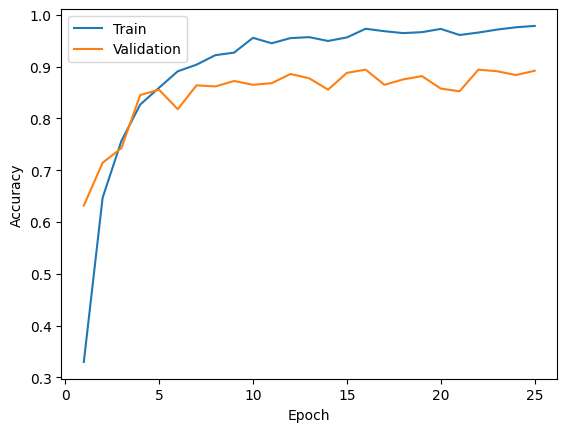

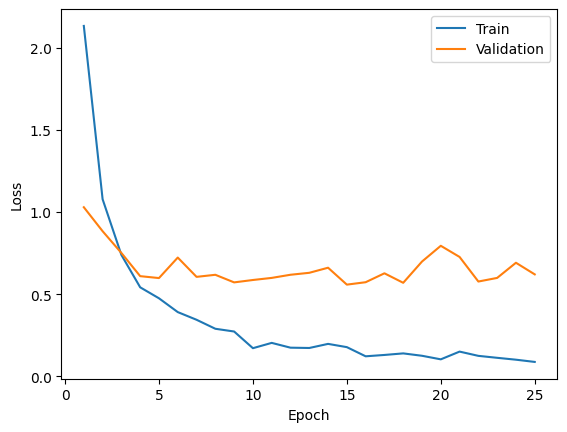

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_acc_history, label='Train')
plt.plot(range(1, num_epochs+1), test_acc_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(range(1, num_epochs+1), train_loss_history, label='Train')
plt.plot(range(1, num_epochs+1), test_loss_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# # Testing loop
# model.eval()
# running_loss = 0.0
# correct_predictions = 0

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct_predictions += (predicted == labels).sum().item()

# test_loss = running_loss / len(test_loader)
# test_accuracy = correct_predictions / len(test_dataset)

# print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")

In [13]:
from torchvision import transforms
from PIL import Image

# Load the custom ResNet model
model = CustomEfficientNet(num_classes=len(categories))  # Replace NUM_CLASSES with the number of classes in your dataset

# Load the pre-trained weights (if any)
# If you have saved your model state_dict, you can load it using:
# model.load_state_dict(torch.load('path_to_your_model_weights.pth'))
# Otherwise, you can skip this step if you trained the model in the same session

# Set the model to evaluation mode
model.eval()

# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the image using PIL
image = Image.open("/home/khushi/Testing_testing/Data/Updated_Data/Needle_Biopsy_Device/Needle biopsy device (for needle biopsy)_0.jpeg")
# Preprocess the image
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Make predictions
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.softmax(output, dim=1)

# Get the predicted class index
predicted_class_index = torch.argmax(probabilities, dim=1).item()

# Optionally, get the class label based on the index
# Assuming you have a list of class labels
class_labels = categories  # Replace with your actual class labels
predicted_class_label = class_labels[predicted_class_index]

print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Label:", predicted_class_label)
print("Class Probabilities:", probabilities)


/home/khushi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khushi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted Class Index: 10
Predicted Class Label: Heart_Lung_Machine
Class Probabilities: tensor([[0.0420, 0.0368, 0.0428, 0.0418, 0.0396, 0.0368, 0.0374, 0.0428, 0.0371,
         0.0373, 0.0441, 0.0391, 0.0424, 0.0393, 0.0396, 0.0380, 0.0431, 0.0436,
         0.0406, 0.0374, 0.0390, 0.0406, 0.0422, 0.0403, 0.0364]])


In [14]:
import os

def count_files(path):
  """Counts the number of files in a directory and its subdirectories."""
  count = 0
  for root, directories, files in os.walk(path):
    for file in files:
      count += 1
  return count

def main():
  """Prints the number of files in each subfolder of the current directory."""
  path = "/home/khushi/Testing_testing/Data/Updated_Data"
  for directory in os.listdir(path):
    count = count_files(os.path.join(path, directory))
    print(f"{directory}: {count}")

if __name__ == "__main__":
  main()

Bone_saws: 174
colonoscope: 128
Straight_Dissection_Clamp: 211
baby_incubator: 188
Electrocautery_devices: 120
ventilator: 214
infusion_pump: 206
Straight_Mayo_Scissor: 216
x_ray: 171
IMRT: 195
forceps: 260
Anaesthesia_machine: 135
Radiofrequency_Ablation_Device: 256
Needle_Biopsy_Device: 200
phacoemulsification: 173
Heart_Lung_Machine: 238
Laryngoscopes: 136
Curved_Mayo_Scissor: 164
IABP: 200
C_arm: 153
mayfield_clamp: 219
Suction_Machine: 273
difibrillator: 172
Scalpel: 217
fetal_doppler: 159
